# Fashion Image segmentation with a U-Net-like architecture

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

We will use the U-Net architecture to perform image segmentation on the [Fashionpedia](https://fashionpedia.github.io/home/) dataset. The dataset consists of 45,623 images in training set and 1158 for validation. There are a high variety of different sizes and aspect ratios in the dataset. The images are annotated with 46 different categories of fashion items. In order to include background detection, we will add an additional class to the dataset.

The categories that we will use are:

```yaml
0 : shirt, blouse
1 : top, t-shirt, sweatshirt
2 : sweater
3 : cardigan
4 : jacket
5 : vest
6 : pants
7 : shorts
8 : skirt
9 : coat
10 : dress
11 : jumpsuit
12 : cape
13 : glasses
14 : hat
15 : headband, head covering, hair accessory
16 : tie
17 : glove
18 : watch
19 : belt
20 : leg warmer
21 : tights, stockings
22 : sock
23 : shoe
24 : bag, wallet
25 : scarf
26 : umbrella
27 : hood
28 : collar
29 : lapel
30 : epaulette
31 : sleeve
32 : pocket
33 : neckline
34 : buckle
35 : zipper
36 : applique
37 : bead
38 : bow
39 : flower
40 : fringe
41 : ribbon
42 : rivet
43 : ruffle
44 : sequin
45 : tassel

```

## Prepare paths of input images and target segmentation masks

Our file structure is mainly composed by the following structure:

```bash
datasets/
├── fashion
│   ├── annotations
│   │   ├── train2020
│   │   └── val2020
│   ├── images
│   │   ├── test2020
│   │   ├── train2020
│   │   └── val2020
│   └── splits
```

The annotations were originally in JSON format and it was necessary to convert them to PNG masks. The following code was used to convert the JSON files to PNG masks.

In [19]:
import os
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2

import keras
import tensorflow as tf

from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


from keras import layers


input_dir_train = "datasets/fashion/images/train2020"
target_dir_train = "datasets/fashion/annotations/train2020"

input_dir_val = "datasets/fashion/images/val2020"
target_dir_val = "datasets/fashion/annotations/val2020"

input_dir_test = "datasets/fashion/images/test2020"
target_dir_test = "datasets/fashion/annotations/test2020"

img_size = (256, 256)
num_classes = 47
batch_size = 32

train_img_paths = sorted(
    [
        os.path.join(input_dir_train, fname)
        for fname in os.listdir(input_dir_train)
        if fname.endswith(".jpg")
    ]
)

val_img_paths = sorted(
    [
        os.path.join(input_dir_val, fname)
        for fname in os.listdir(input_dir_val)
        if fname.endswith(".jpg")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(input_dir_test, fname)
        for fname in os.listdir(input_dir_test)
        if fname.endswith(".jpg")
    ]
)

train_target_img_paths = sorted(
    [
        os.path.join(target_dir_train, fname)
        for fname in os.listdir(target_dir_train)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_target_img_paths = sorted(
    [
        os.path.join(target_dir_val, fname)
        for fname in os.listdir(target_dir_val)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of validation samples:", len(val_img_paths))
print("Number of test samples:", len(test_img_paths))

for input_path, target_path in zip(train_img_paths[:10], train_target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of train samples: 45623
Number of validation samples: 1158
Number of test samples: 2042
datasets/fashion/images/train2020/00000663ed1ff0c4e0132b9b9ac53f6e.jpg | datasets/fashion/annotations/train2020/00000663ed1ff0c4e0132b9b9ac53f6e_seg.png
datasets/fashion/images/train2020/0000fe7c9191fba733c8a69cfaf962b7.jpg | datasets/fashion/annotations/train2020/0000fe7c9191fba733c8a69cfaf962b7_seg.png
datasets/fashion/images/train2020/0002ec21ddb8477e98b2cbb87ea2e269.jpg | datasets/fashion/annotations/train2020/0002ec21ddb8477e98b2cbb87ea2e269_seg.png
datasets/fashion/images/train2020/0002f5a0ebc162ecfb73e2c91e3b8f62.jpg | datasets/fashion/annotations/train2020/0002f5a0ebc162ecfb73e2c91e3b8f62_seg.png
datasets/fashion/images/train2020/0004467156e47b0eb6de4aa6479cbd15.jpg | datasets/fashion/annotations/train2020/0004467156e47b0eb6de4aa6479cbd15_seg.png
datasets/fashion/images/train2020/00048c3a2fb9c29340473c4cfc06424a.jpg | datasets/fashion/annotations/train2020/00048c3a2fb9c29340473c4cfc06

In [20]:
COLORS = [
    (0, 0, 0), (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184),
    (20, 165, 16), (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122),
    (43, 152, 125), (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116),
    (216, 21, 138), (100, 0, 176), (171, 236, 47), (193, 137, 224), (36, 152, 214), (154, 165, 67), (73, 8, 110),
    (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184), (20, 165, 16),
    (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122), (43, 152, 125),
    (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198)
]

d_cats = {0: 'shirt, blouse', 1: 'top, t-shirt, sweatshirt', 2: 'sweater', 3: 'cardigan', 4: 'jacket', 5: 'vest', 6: 'pants', 7: 'shorts', 
          8: 'skirt', 9: 'coat', 10: 'dress', 11: 'jumpsuit', 12: 'cape', 13: 'glasses', 14: 'hat', 15: 'headband, head covering, hair accessory', 
          16: 'tie', 17: 'glove', 18: 'watch', 19: 'belt', 20: 'leg warmer', 21: 'tights, stockings', 22: 'sock', 23: 'shoe', 24: 'bag, wallet', 
          25: 'scarf', 26: 'umbrella', 27: 'hood', 28: 'collar', 29: 'lapel', 30: 'epaulette', 31: 'sleeve', 32: 'pocket', 33: 'neckline', 
          34: 'buckle', 35: 'zipper', 36: 'applique', 37: 'bead', 38: 'bow', 39: 'flower', 40: 'fringe', 41: 'ribbon', 42: 'rivet', 43: 'ruffle', 
          44: 'sequin', 45: 'tassel'}

d_cats = {k+1:v for k, v in d_cats.items()}
d_cats[0] = 'background'
print("Number of classes: ", len(d_cats))


def process_overlay_mask(mask):
    mask = np.array(mask).astype(int)
    # ax[i, 0].imshow(image, cmap='gray')
        # For all the values in the mask, we will create a new mask with the same shape but with the color of the category
    mask_color = np.zeros((mask.shape[0], mask.shape[1], 3))
    for i_ in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            try:
                mask_color[i_, j] = COLORS[mask[i_, j][0]]
            except:
                mask_color[i_, j] = COLORS[mask[i_, j]]
    mask_color = mask_color.astype(np.uint8)
    return mask_color

Number of classes:  47


## What does one input image and corresponding segmentation mask look like?

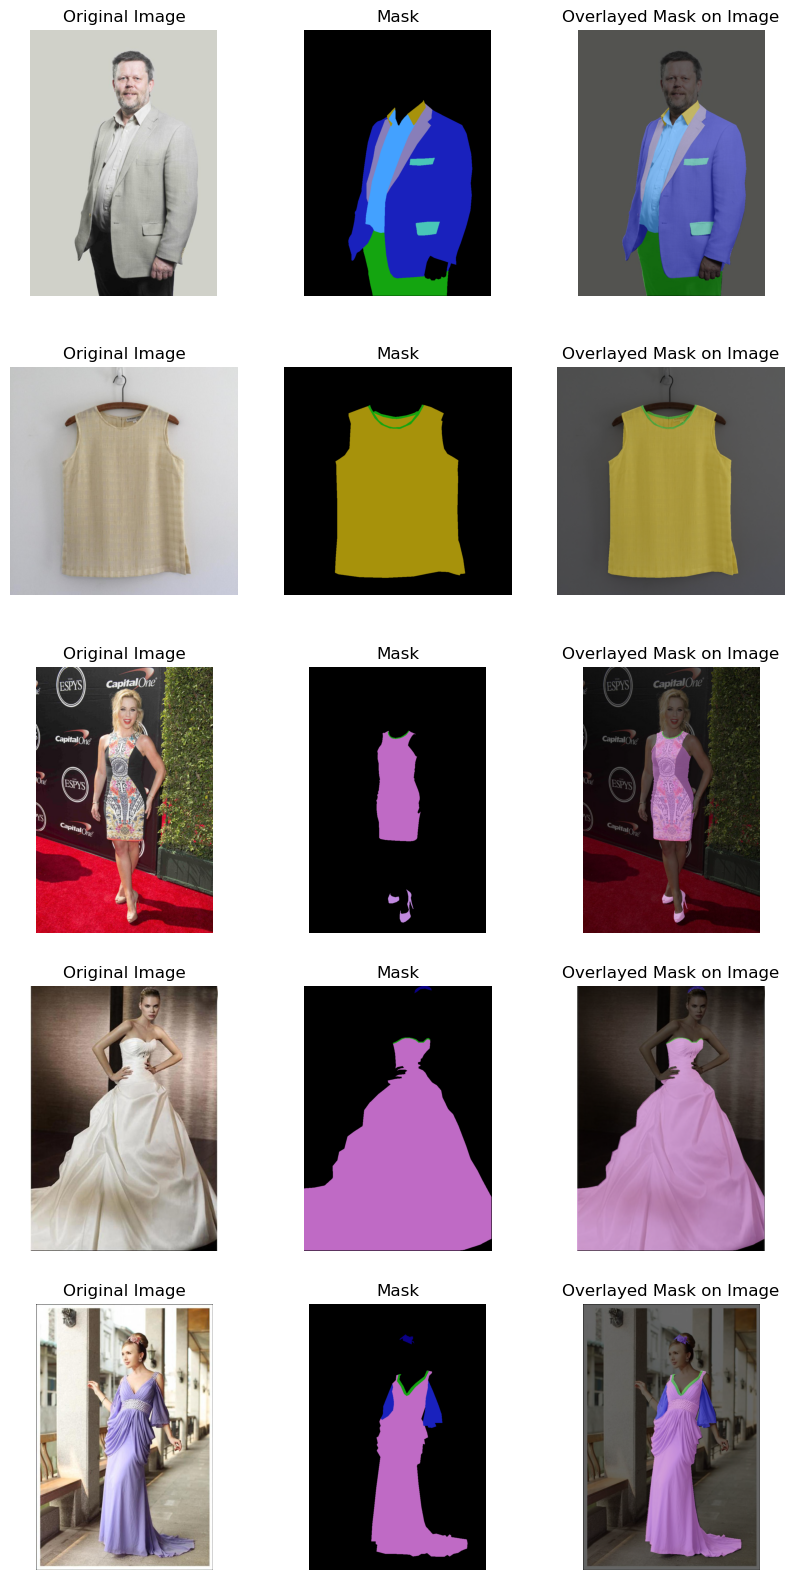

In [22]:
# Display input image #7
# display(Image(filename=train_img_paths[9]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = ImageOps.autocontrast(load_img(train_target_img_paths[9]))
# display(img)

n_imgs = 5
alpha = 0.6

fig, ax = plt.subplots(n_imgs, 3, figsize=(10, 20))
for i in range(n_imgs):
    image = np.array(load_img(train_img_paths[i]))
    mask = np.array(load_img(train_target_img_paths[i]))

    mask_color = process_overlay_mask(mask)
    
    ax[i ,0].imshow(image)
    ax[i, 0].set_title("Original Image")

    # Combine original image with colored mask
    image1 = cv2.addWeighted(image * 1.0, 1 - alpha, mask_color * 1.0, alpha, 0).astype(np.uint8)
    ax[i ,1].imshow(mask_color)
    ax[i, 1].set_title("Mask")

    ax[i, 2].imshow(image1)
    ax[i, 2].set_title("Overlayed Mask on Image")
    
    # axis off for all subplots
    for j in range(3):
        ax[i, j].axis('off')


## Prepare dataset to load & vectorize batches of data

In [4]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

2024-03-26 18:21:29.510627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 18:21:29.567274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 18:21:29.567423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Set aside a validation split

In [6]:
# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_img_paths,
    train_target_img_paths,
    # max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_img_paths, val_target_img_paths
)

## Train the model

As this is a classification problem, we will use the categorical crossentropy loss function. The Adam optimizer is used with a learning rate of 0.0001. The model will be trained for 5 epochs with a batch size of 32.

Due to computational time and complexity, all the images have been resized to 256x256 pixels. This makes the model less accurate but it is a good starting point.

In [7]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("fashion_256.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/10


2024-03-26 18:21:31.083224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-26 18:21:31.201549: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-26 18:21:31.201564: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-03-26 18:21:31.201603: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-26 18:21:34.373147: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory

1426/1426 [==============================] - 396s 271ms/step - loss: 0.8258 - val_loss: 0.5598
Epoch 2/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.6194 - val_loss: 0.4799
Epoch 3/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.5484 - val_loss: 0.4298
Epoch 4/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.5036 - val_loss: 0.4040
Epoch 5/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.4719 - val_loss: 0.3902
Epoch 6/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.4475 - val_loss: 0.3775
Epoch 7/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.4274 - val_loss: 0.3690
Epoch 8/10
1426/1426 [==============================] - 380s 266ms/step - loss: 0.4102 - val_loss: 0.3627
Epoch 9/10
1426/1426 [==============================] - 380s 267ms/step - loss: 0.3951 - val_loss: 0.3587
Epoch 10/10
1426/1426 [==============================] - 

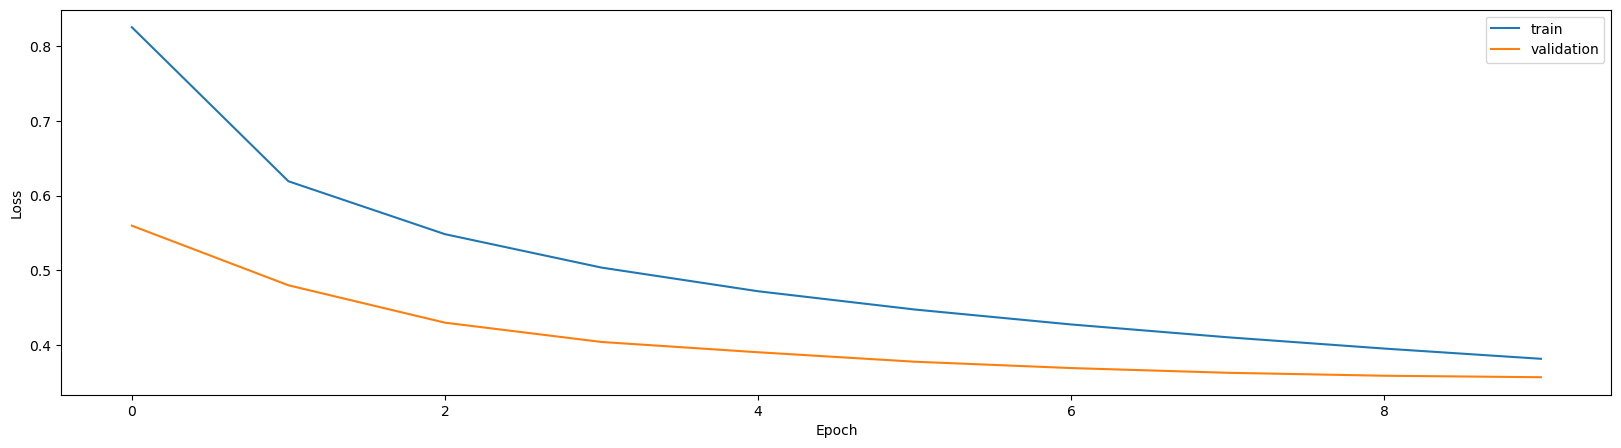

In [8]:
# plot history
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(history.history["loss"], label="train")
ax.plot(history.history["val_loss"], label="validation")

# ax[1].plot(history.history["accuracy"], label="train")
# ax[1].plot(history.history["val_accuracy"], label="validation")

ax.set_xlabel("Epoch")
# ax[1].set_xlabel("Epoch")


ax.set_ylabel("Loss")
# ax[1].set_ylabel("Mean IoU")

plt.legend()
plt.show()


As it can be seen from previous loss values, the model could still be improved by increasing the number of epochs. However, the training time is too high for the kernel.

## Visualize predictions

In order to better visualize the predictions, we will use some auxiliary functions to plot the images and masks.


In [9]:
model = keras.models.load_model("fashion_256x512.keras")

1/1 [==============================] - 0s 13ms/step


Text(0.5, 1.0, 'Original Image with Predicted Mask')

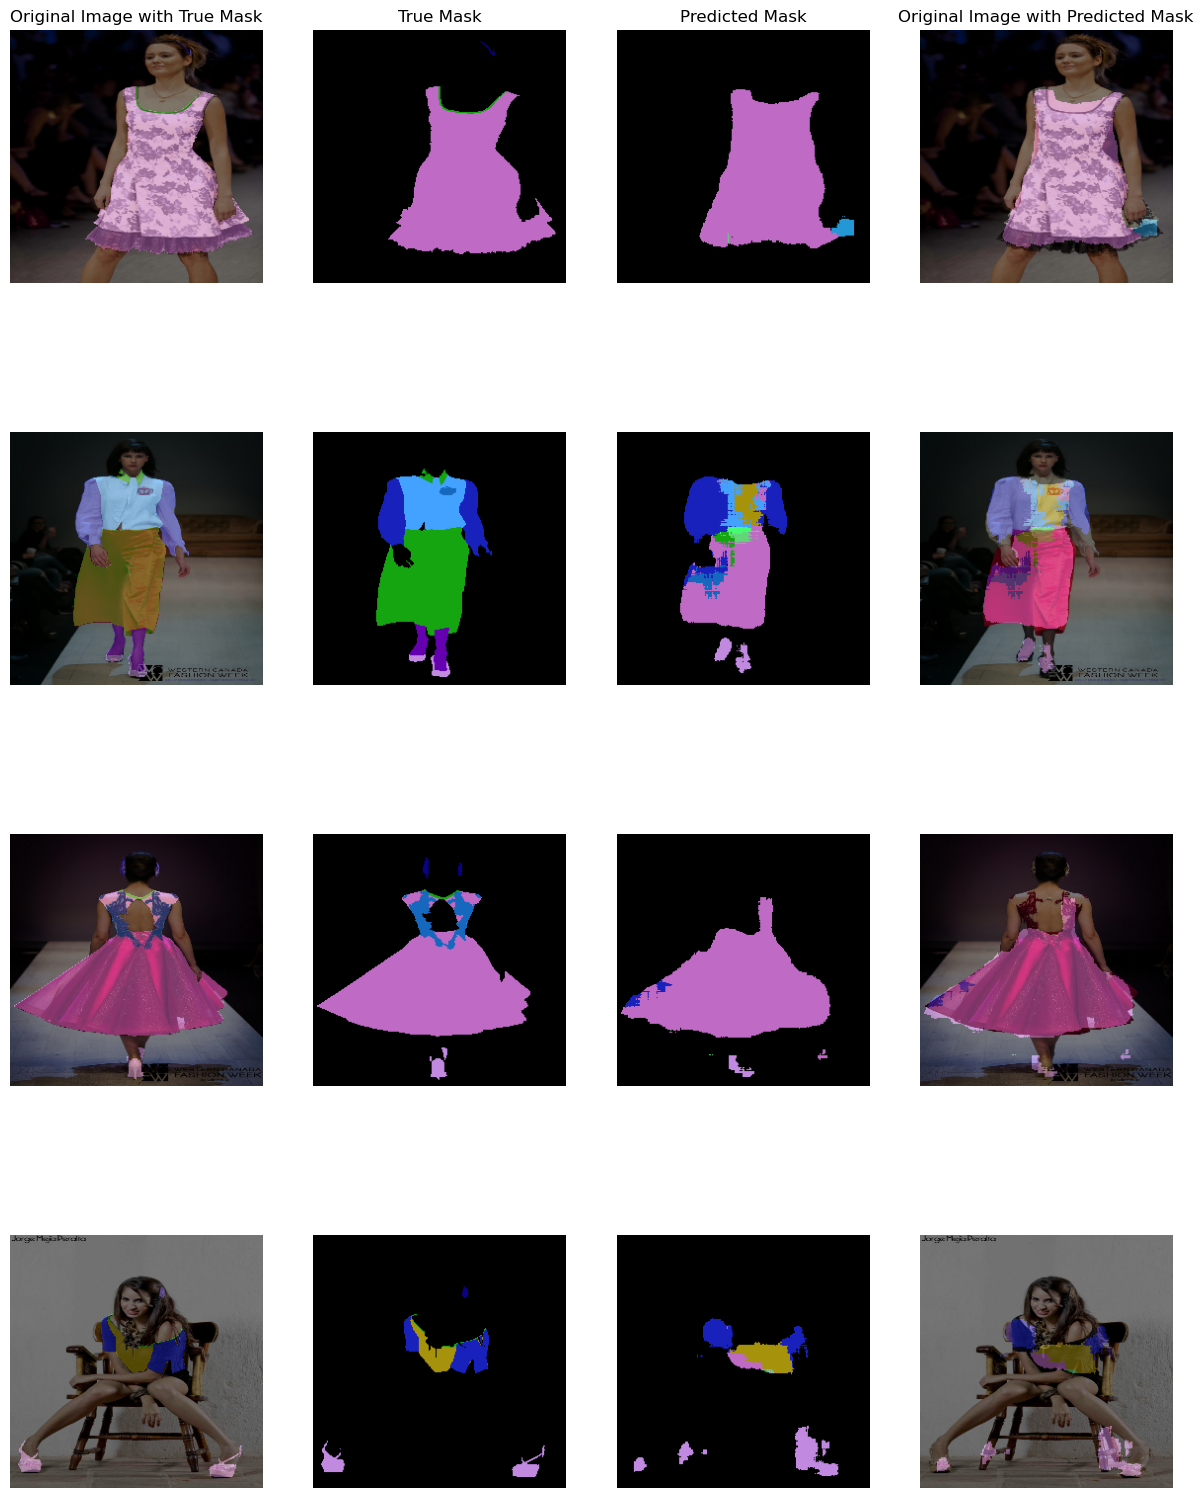

In [10]:
val_dataset_examples = get_dataset(
                                        batch_size, img_size, val_img_paths[:4], val_target_img_paths[:4]
                                    )

fig, ax = plt.subplots(4, 4, figsize=(15, 20))
alpha = 0.5
i = 0
for img_batch, mask_batch in val_dataset_examples:
    for image, mask in zip(img_batch, mask_batch):
        image = np.array(image).astype(int)

        mask_color = process_overlay_mask(mask)

        # Combine original image with colored mask
        image1 = cv2.addWeighted(image * 1.0, 1 - alpha, mask_color * 1.0, alpha, 0).astype(np.uint8)
        ax[i ,0].imshow(image1)

        ax[i, 1].imshow(mask_color)

        pred_mask = model.predict(np.array([image]))
        pred_mask = np.argmax(pred_mask[0], axis=-1)
        pred_mask = process_overlay_mask(pred_mask)
        ax[i, 2].imshow(pred_mask)

        pred_mask = cv2.addWeighted(image * 1.0, 1 - alpha, pred_mask * 1.0, alpha, 0).astype(np.uint8)

        ax[i, 3].imshow(pred_mask)
        # plt.show()

        for j in range(4):
            ax[i, j].axis('off')
            
        i += 1

ax[0, 0].set_title("Original Image with True Mask")
ax[0, 1].set_title("True Mask")
ax[0, 2].set_title("Predicted Mask")
ax[0, 3].set_title("Original Image with Predicted Mask")

# Model Validation Metrics

## Intersection over Union (IoU)

This metric measures the overlap between predicted predicted segmentation map and the real one, with scores ranging from 0 to 1. The higher the score, the better the model is at predicting the correct segmentation map.

$$
IoU = \frac{TP}{TP + FP + FN}
$$

In [11]:
import tensorflow as tf
from tqdm import tqdm


def get_iou(dataset, model):    
    # Calculate the mean IoU
    iou = []

    for img_batch, mask_batch in tqdm(dataset):
        for image, mask in zip(img_batch, mask_batch):
            pred_mask = model.predict(np.array([image]), verbose=0)
            pred_mask = np.argmax(pred_mask[0], axis=-1)
            m = tf.keras.metrics.MeanIoU(num_classes=47)
            m.update_state(mask, pred_mask)
            iou.append(m.result().numpy())

    return iou

iou = get_iou(valid_dataset, model)
print("\n\n")
print("Validation IOU", np.mean(iou), "+-", np.std(iou))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:41<00:00,  1.11s/it]




Validation IOU 0.22217973 +- 0.11173141


# Get the center of the objects

The output of the model has a layer for each class. We will use the output of the model to get the center of the objects.

The center has been computed as the mean of the x and y coordinates of the mask.

In addition to this, a confidence threshold of 0.4 has been used to filter those predictions with a low confidence and avoid sparse false positives.

1/1 [==============================] - 0s 16ms/step


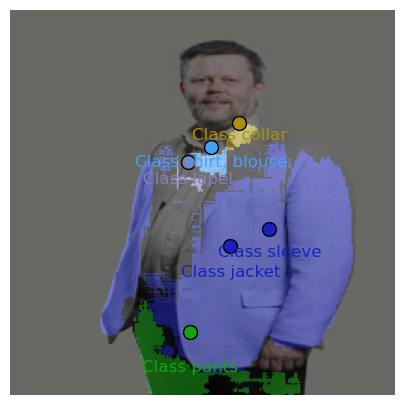

1/1 [==============================] - 0s 15ms/step


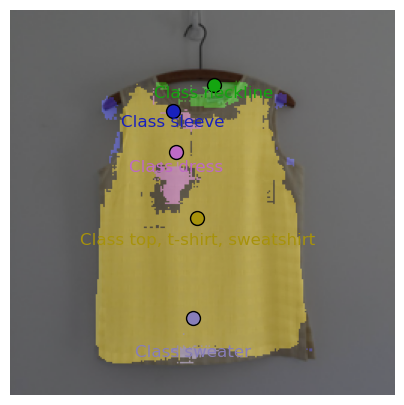

1/1 [==============================] - 0s 15ms/step


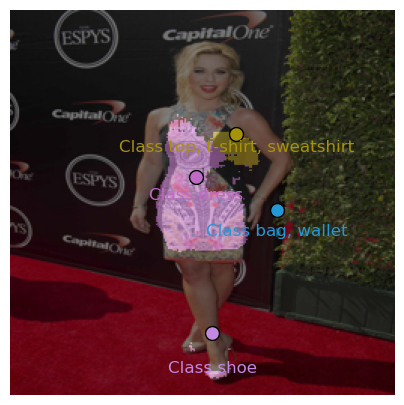

1/1 [==============================] - 0s 20ms/step


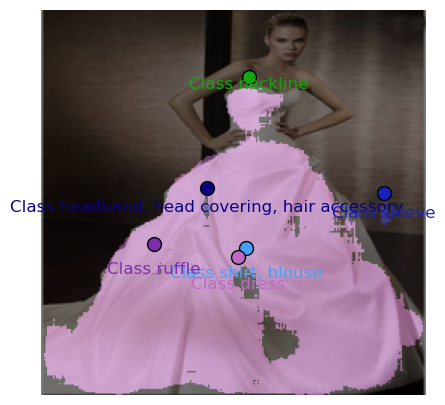

1/1 [==============================] - 0s 15ms/step


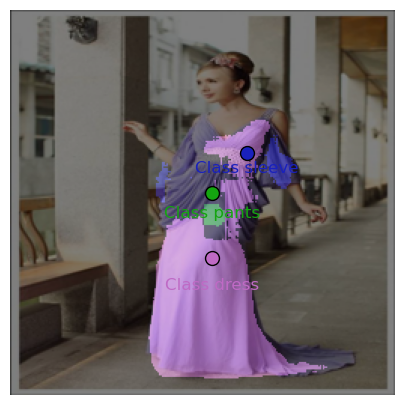

1/1 [==============================] - 0s 14ms/step


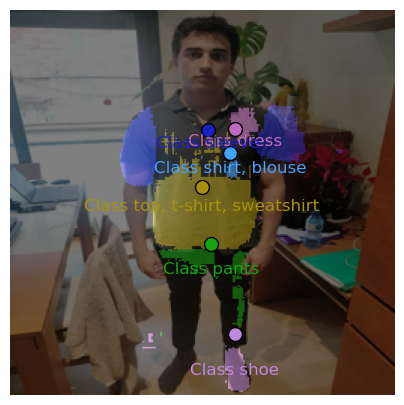

In [16]:
# pred_number = 5
conf_thresh = 0.6
url = '/home/alberto/Descargas/fernando.jpeg'


for pn in range(6):
    if pn < 5:
        image = np.array(load_img(train_img_paths[pn]).resize((256, 256)))
    else:
        image = np.array(load_img(url).resize((256, 256)))
        
    pred_mask = model.predict(np.array([image]))

    pred_mask_max = np.max(pred_mask[0], axis=-1)
    pred_mask = np.argmax(pred_mask[0], axis=-1)

    pred_mask = np.where(pred_mask_max > 0.4, pred_mask, 0)


    # for each of the non-zero classes, calculate the center
    d_centers = {}
    for i in np.unique(pred_mask):
        if i == 0:
            continue

        binary_mask = pred_mask == i
        # if not mask.any():
        #     continue
        # Assume binary_mask is a 2D numpy array with dtype bool
        centroid = np.mean(np.argwhere(binary_mask),axis=0)
        centroid_x, centroid_y = int(centroid[1]), int(centroid[0])

        d_centers[d_cats[i]] = (centroid_x, centroid_y)

    # plot the centers

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for (i, (center_x, center_y)) in d_centers.items():
        n_class = list(d_cats.keys())[list(d_cats.values()).index(i)]
        plt.plot(center_x, center_y*0.9, 'o', markersize=10, color=np.array(COLORS[n_class]) / 255, markeredgecolor='black')
        ax.annotate(f"Class {i}", (center_x, center_y), fontsize=12, ha='center', va='center', color = np.array(COLORS[n_class]) / 255)



    pred_mask_ = process_overlay_mask(pred_mask)

    image_ = cv2.addWeighted(image * 1.0, 1 - alpha, pred_mask_ * 1.0, alpha, 0).astype(np.uint8)
    ax.imshow(image_)
    plt.axis('off')
    plt.show()



# Conclusion

A U-Net-like architecture has been used to perform image segmentation on the Fashionpedia dataset. The model has been trained from scratch and has achieved a low performance in terms of IoU. The model could be further improved by increasing the number of epochs and the image size.

Fine-tuning a pre-trained used to identify persons would achieve better results.